In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

path = "/content/drive/My Drive/capFantasticFour/"

In [4]:
d = pd.read_csv(path + "Datasets/balanced_data.csv")

In [5]:
d.head()

,Label,Preprocessed_Content,sentiment,hate_speech_count,pos_tags,word2vec,sbert_embedding,lexical_diversity,sentence_complexity
0,0,politic power g g lot power accord constitutio...,-0.053125,1,"['ADJ', 'NOUN', 'NOUN', 'PROPN', 'NOUN', 'NOUN...",[-0.03289668 0.02179972 0.03996785 0.122357...,[-5.88354059e-02 1.34056015e-02 2.37510502e-...,0.791667,0
1,1,differentiate white man white car,0.000000,0,"['ADJ', 'ADJ', 'NOUN', 'ADJ', 'NOUN']",[ 7.32910186e-02 8.39111358e-02 -3.10058594e-...,[ 9.96661186e-03 1.11034006e-01 2.08890960e-...,0.800000,0
2,1,requirement job president male stillwater hill...,0.000000,0,"['NOUN', 'NOUN', 'NOUN', 'PROPN', 'PROPN', 'PR...",[-6.61621094e-02 3.15115787e-02 2.76576448e-...,[-5.81887439e-02 1.36256441e-02 1.53751895e-...,1.000000,0
3,0,mmm yes slut lazy henceforth use undo thank br...,-0.066667,1,"['INTJ', 'INTJ', 'PROPN', 'PROPN', 'ADV', 'VER...",[-0.04728917 0.02167184 -0.00804901 0.138368...,[-8.70714635e-02 6.90844133e-02 5.56385703e-...,0.821429,0
4,0,easy dennis brown hack wikipedia account write...,0.433333,0,"['PROPN', 'PROPN', 'PROPN', 'PROPN', 'PROPN', ...",[ 4.82566133e-02 3.74228731e-02 -5.38690723e-...,[-5.78395948e-02 1.60150453e-02 -5.26245423e-...,1.000000,0


In [6]:
d['sbert_embedding'].shape

(60000,)

In [7]:
def convert_embedding(embedding):
    if isinstance(embedding, np.ndarray):
        return embedding
    elif isinstance(embedding, list):
        return np.array(embedding, dtype=np.float32)
    elif isinstance(embedding, str):
        embedding = embedding.strip("[]")
        embedding = np.array([float(x) for x in embedding.split()], dtype=np.float32)
        return embedding
    else:
        return np.zeros(768, dtype=np.float32)

d['sbert_embedding'] = d['sbert_embedding'].apply(convert_embedding)

embeddings = np.stack(d['sbert_embedding'].values)


print("Embeddings Shape:", embeddings.shape)

Embeddings Shape: (60000, 384)


In [8]:
#faiss_index = faiss.IndexFlatL2(embeddings.shape[1])
#faiss_index.add(embeddings)

In [9]:
tfidf = TfidfVectorizer(ngram_range=(2, 3), stop_words='english')
X_tfidf = tfidf.fit_transform(d['Preprocessed_Content'])

In [10]:
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X_bow = vectorizer.fit_transform(d['Preprocessed_Content'])

In [11]:
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(d[['sentiment', 'hate_speech_count', 'lexical_diversity', 'sentence_complexity']])
dense_features = csr_matrix(scaled_numerical_features)

In [12]:
X = hstack([
    X_tfidf,
    #X_bow,
    embeddings,
    #dense_features
])


X.shape

(60000, 1167921)

In [13]:
Y = d['Label']

**Will use only bert embeddings here as it will crash**

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, Y, test_size=0.2, random_state=42)

In [15]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (48000, 384)
Y_train shape: (48000,)
X_test shape: (12000, 384)
Y_test shape: (12000,)


In [16]:
# Reshape embeddings for LSTM (sequence length = 1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# for hstack features
#X_train = X_train.toarray().reshape((X_train.shape[0], 1, X_train.shape[1]))
#X_test = X_test.toarray().reshape((X_test.shape[0], 1, X_test.shape[1]))

In [17]:
X_train.shape[1]

1

In [18]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (48000, 1, 384)
Y_train shape: (48000,)
X_test shape: (12000, 1, 384)
Y_test shape: (12000,)


In [19]:
lstm_model = Sequential()


lstm_model.add(LSTM(128, return_sequences=False, input_shape=(1, 384)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,785 (1.00 MB)

 Trainable params: 262,785 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [21]:
batch_size = 256
epochs  = 200

history = lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_test, np.asarray(Y_test)), batch_size = batch_size, epochs = epochs, callbacks=[early_stopping])


Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7262 - loss: 0.6017 - val_accuracy: 0.7807 - val_loss: 0.4700
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7795 - loss: 0.4725 - val_accuracy: 0.7896 - val_loss: 0.4559
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7818 - loss: 0.4623 - val_accuracy: 0.7910 - val_loss: 0.4496
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7881 - loss: 0.4542 - val_accuracy: 0.7918 - val_loss: 0.4470
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7887 - loss: 0.4522 - val_accuracy: 0.7940 - val_loss: 0.4428
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7918 - loss: 0.4445 - val_accuracy: 0.7958 - val_loss: 0.4403
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7917 - loss: 0.4454 - val_accuracy: 0.7962 - val_loss: 0.4371
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7968 - loss: 0.4395 -

In [22]:
lstm_model.save(path+'lstm_hs.keras')


In [23]:
#from tensorflow.keras.models import load_model
#loaded_model = load_model('lstm_hs.h5')

In [24]:
# Predictions (threshold of 0.5)
y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)

# Calculate Precision, Recall, F1 Score, and Accuracy
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

# Print metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy : {:.4f}".format(accuracy))

# Display classification report (includes precision, recall, f1 score)
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred, target_names=['Non-Hate', 'Hate']))

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precision: 0.8108
Recall: 0.8550
F1 Score: 0.8323
Accuracy : 0.8259

Classification Report:

              precision    recall  f1-score   support

    Non-Hate       0.84      0.80      0.82      5937
        Hate       0.81      0.86      0.83      6063

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000



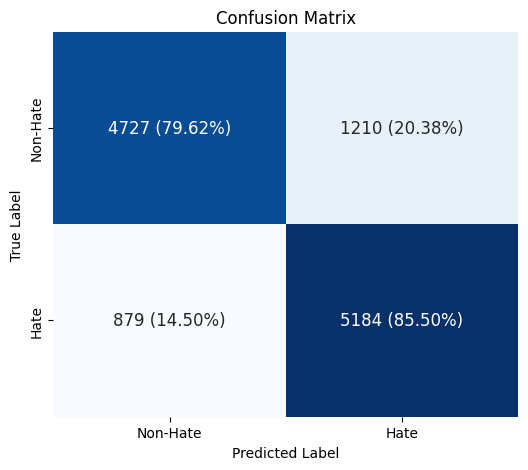

In [25]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a combined matrix for annotations
    combined_matrix = np.array([["{} ({:.2f}%)".format(cm[i, j], cm_percent[i, j])
                                for j in range(cm.shape[1])]
                               for i in range(cm.shape[0])])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=combined_matrix, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                annot_kws={"size": 12})

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(Y_test, y_pred)

In [26]:
from tensorflow.keras.layers import Bidirectional

bilstm_model = Sequential()

bilstm_model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, 384)))
bilstm_model.add(Dropout(0.5))

bilstm_model.add(Dense(1, activation='sigmoid'))

bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(bilstm_model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,569 (2.00 MB)

 Trainable params: 525,569 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
epochs = 200
batch_size = 256

history = bilstm_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size,
                         epochs=epochs, callbacks=[early_stopping])


Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7332 - loss: 0.5853 - val_accuracy: 0.7834 - val_loss: 0.4647
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7801 - loss: 0.4703 - val_accuracy: 0.7907 - val_loss: 0.4530
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7872 - loss: 0.4580 - val_accuracy: 0.7930 - val_loss: 0.4473
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7904 - loss: 0.4480 - val_accuracy: 0.7950 - val_loss: 0.4431
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.7960 - loss: 0.4436 - val_accuracy: 0.7967 - val_loss: 0.4396
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7945 - loss: 0.4406 - val_accuracy: 0.7967 - val_loss: 0.4357
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7985 - loss: 0.4361 - val_accuracy: 0.8010 - val_loss: 0.4309
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8030 - loss: 0.4258 -

In [28]:
bilstm_model.save(path+'bilstm_hs.keras')

In [29]:
# Predictions (threshold of 0.5)
y_pred = (bilstm_model.predict(X_test) > 0.5).astype(int)

# Calculate Precision, Recall, F1 Score, and Accuracy
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

# Print metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy : {:.4f}".format(accuracy))

# Display classification report (includes precision, recall, f1 score)
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred, target_names=['Non-Hate', 'Hate']))

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Precision: 0.8085
Recall: 0.8560
F1 Score: 0.8316
Accuracy : 0.8248

Classification Report:

              precision    recall  f1-score   support

    Non-Hate       0.84      0.79      0.82      5937
        Hate       0.81      0.86      0.83      6063

    accuracy                           0.82     12000
   macro avg       0.83      0.82      0.82     12000
weighted avg       0.83      0.82      0.82     12000



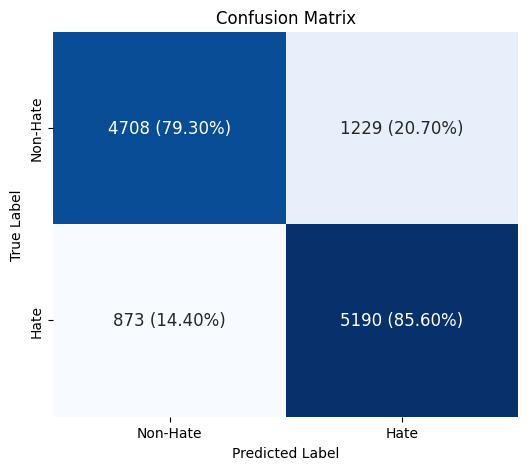

In [30]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a combined matrix for annotations
    combined_matrix = np.array([["{} ({:.2f}%)".format(cm[i, j], cm_percent[i, j])
                                for j in range(cm.shape[1])]
                               for i in range(cm.shape[0])])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=combined_matrix, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                annot_kws={"size": 12})

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(Y_test, y_pred)